In [1]:
import os 
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans

from tqdm.notebook import tqdm

In [2]:
random_seed = 42

# Read data

In [3]:
df = pd.read_excel("test_dataframe.xlsx")

In [4]:
cords_features = ["x_1","x_2"]
unknown_features = [f"x_{i}" for i in range(3, 27)]

In [5]:
df.head()

,name,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26
0,object_1,4.444343,10803.891562,1893.090568,3.195,1.756747,2.804390,1.214452,16.276845,17.900514,...,17.755065,11.625427,25.982397,4.253154,0.120292,51.508254,100.331803,24.074581,2.118523,135.095
1,object_2,1.542500,10802.986261,1894.091476,10.000,0.927789,1.672746,2.037672,17.591819,19.198500,...,18.924773,12.972862,26.915673,3.055868,0.134913,50.468519,100.775339,25.411288,0.964468,353.925
2,object_3,1.548611,10802.290812,1894.434150,3.600,0.588972,0.997910,2.323546,18.357680,19.969280,...,19.426871,13.681034,27.628010,2.287929,0.254675,50.106037,100.750034,26.164441,0.254675,447.280
3,object_4,3.061224,10803.545629,1892.791004,3.675,1.980765,2.638067,0.823431,16.399447,18.045014,...,17.532476,11.617009,26.210830,4.053203,0.070705,51.790560,99.902078,24.153369,1.953486,137.335
4,object_5,10.507881,10802.779639,1893.160768,2.855,1.131793,1.795777,1.121031,17.243937,18.893356,...,18.070901,12.402956,26.991966,3.202651,0.076344,51.391867,99.858352,24.979979,1.104114,250.675


# Генерация фичей

Так как линейная регрессия - линейна, добавляем нелинейность а.к.а. произведение всех фичей на все фичи

In [6]:
def add_features(x, feats):
    temp_x = x.copy()
    new_features = {}

    for feat_x in feats:
        for feat_y in feats:
            new_features[f"{feat_x}-{feat_y}"] = temp_x[feat_x]*temp_x[feat_y] 
            if(feat_x == feat_y):
                break
            
    feats = pd.DataFrame(new_features)
    return pd.concat([x, feats], axis=1)

## Работа с координатами

Стоит выбрать полезные данные из координат

Изначально иедя была в том что бы разбить все записи на кластера(изначально делал ручками, но терпения не хватило) и сделать новую характеристику описывающую растояние от центра кластера, но толку было мало.

Использовал кСредних(надеюсь интерпритируемость присутствует), и добавил бинарную фичу принадлежности к классу.

In [7]:
if(os.path.isfile('geo_cluster.pickle')):
    with open('geo_cluster.pickle','rb') as file:
        geo_cluster = pickle.load(file)
else:
    geo_cluster = KMeans(random_state=random_seed).fit(df[['x_1', 'x_2']])
    with open('geo_cluster.pickle','wb') as file:
        pickle.dump(geo_cluster, file)

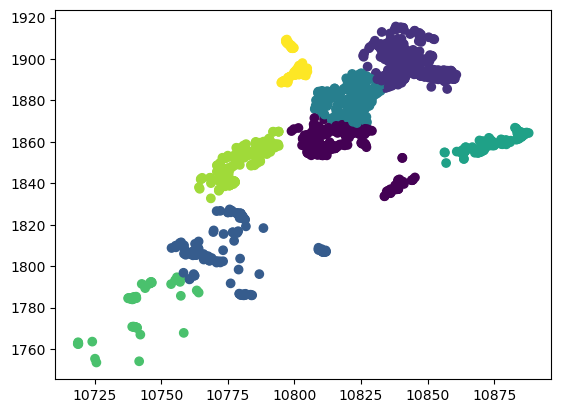

In [8]:
clusters = geo_cluster.predict(df[['x_1','x_2']])

plt.scatter(df['x_1'], df['x_2'], c=clusters)
plt.show()

### OHE кластеры

In [9]:
cluster_feats = np.zeros((clusters.size, clusters.max() + 1))
cluster_feats[np.arange(clusters.size), clusters] = 1
cluster_feats = cluster_feats.reshape([8, -1])
cluster_feats = {f"cluster{i}":clust for i, clust in enumerate(cluster_feats[:])}

cluster_feats = pd.DataFrame(cluster_feats)

df = pd.concat([df, cluster_feats], axis = 1)

cluster_feats = list(cluster_feats.columns)

### Растояние до центра кластера

In [10]:
dist_dict = {}

for clust in cluster_feats:
    mean_x = df[df[clust] == 1]["x_1"].mean()
    mean_y = df[df[clust] == 1]["x_2"].mean()
    # print(mean_x, mean_y)
    dist_dict[f"dist_{clust}"] = (df["x_1"] - mean_x) * (df["x_2"] - mean_y)

dist_dict = pd.DataFrame(dist_dict)

df = pd.concat([df, dist_dict], axis = 1)

dist_feats = list(dist_dict.columns)

# Удаление выбросов

Удаляем значения которые отходят от квантиля, более чем на полтора размаха

In [11]:
for feature in unknown_features:
    q75, q25 = df[feature].quantile(0.75), df[feature].quantile(0.25)
    intr_qr = q75-q25
    maxp = q75+(1.5*intr_qr)
    minp = q25-(1.5*intr_qr)
    mask = (df[feature] < maxp) & (df[feature] > minp)
    
    df[feature][~mask] = None

C:\Users\sereg\AppData\Local\Temp\ipykernel_13348\468860659.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature][~mask] = None


In [12]:
df.isna().sum()

name               0
y                  0
x_1                0
x_2                0
x_3               90
x_4               73
x_5               84
x_6               16
x_7                0
x_8              137
x_9              168
x_10             165
x_11              51
x_12              40
x_13              22
x_14               0
x_15             218
x_16              84
x_17              48
x_18             287
x_19             131
x_20               5
x_21             207
x_22              65
x_23               0
x_24             306
x_25             219
x_26             173
cluster0           0
cluster1           0
cluster2           0
cluster3           0
cluster4           0
cluster5           0
cluster6           0
cluster7           0
dist_cluster0      0
dist_cluster1      0
dist_cluster2      0
dist_cluster3      0
dist_cluster4      0
dist_cluster5      0
dist_cluster6      0
dist_cluster7      0
dtype: int64

In [13]:
clear_df = df[df.isna().sum(axis = 1) == 0]
clear_df.shape

(1126, 44)

In [14]:
filled_df = df.fillna(df[unknown_features].mean(axis = 0))

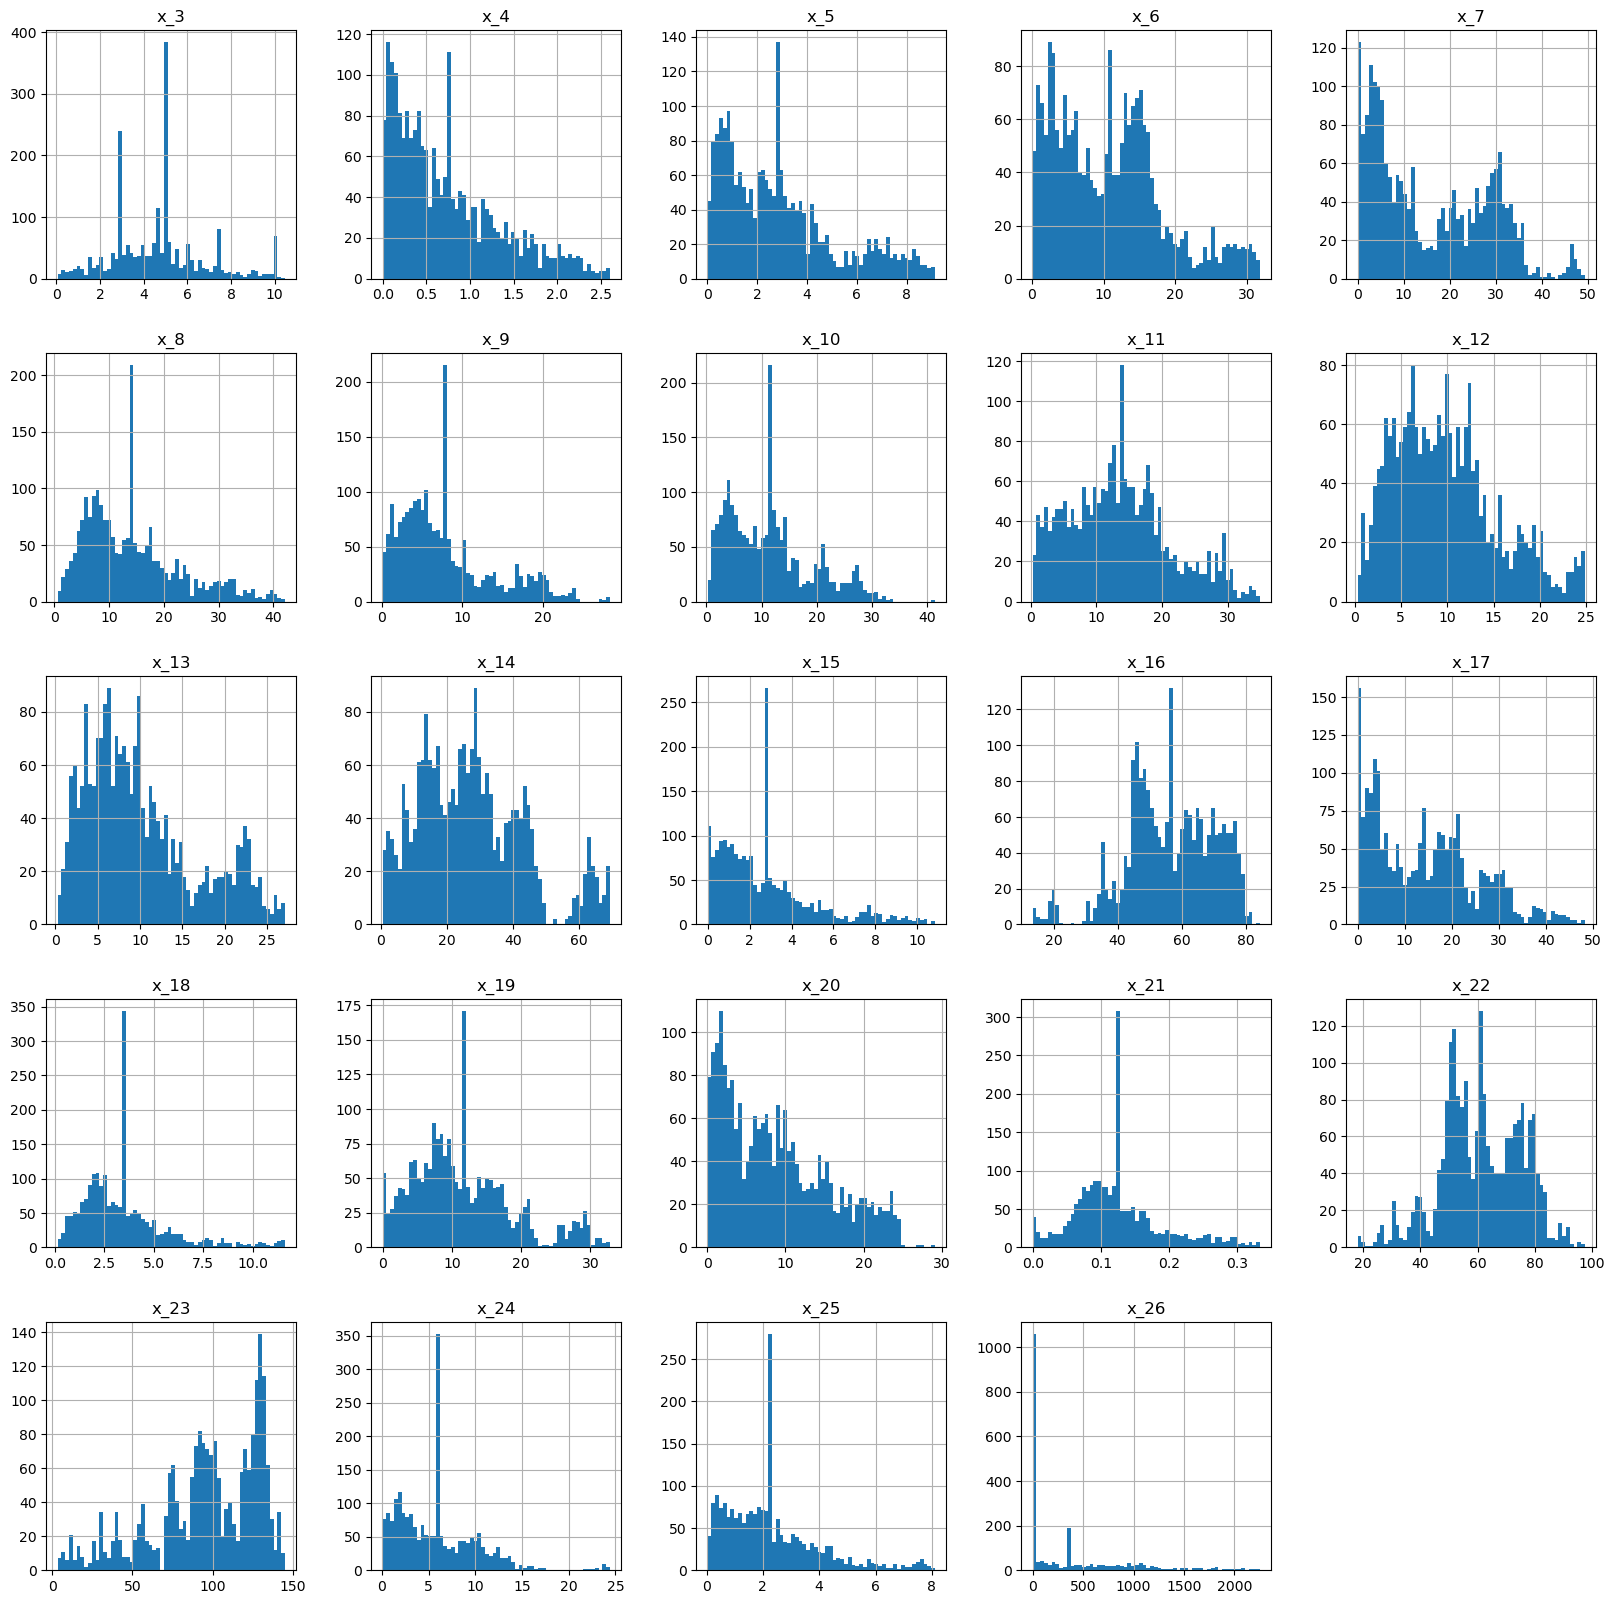

In [15]:
filled_df[unknown_features].hist(bins=60,figsize=(20, 20))
plt.show()

In [16]:
features = cords_features + unknown_features + cluster_feats + dist_feats

 # Анализ целевой переменной

<AxesSubplot: >

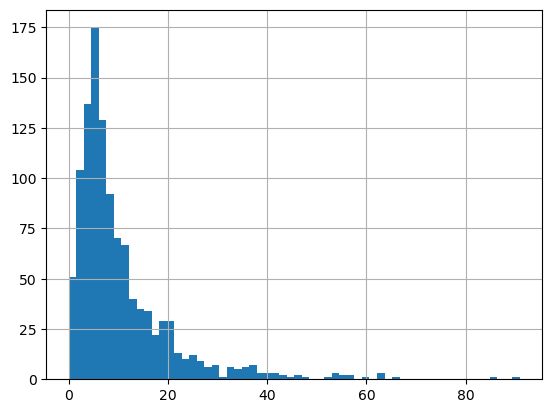

In [17]:
clear_df['y'].hist(bins = 60)

<AxesSubplot: >

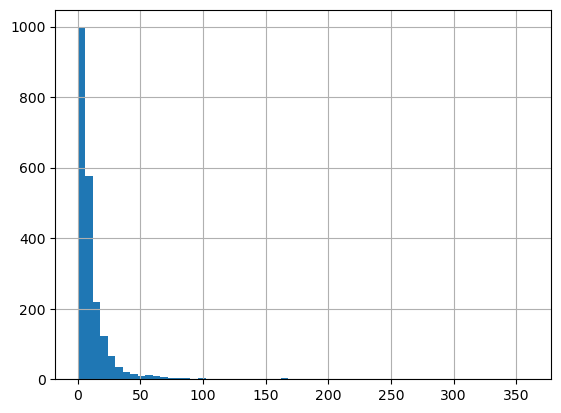

In [18]:
filled_df['y'].hist(bins = 60)

In [19]:
filled_df['y'].describe()

count    2123.000000
mean       11.816234
std        20.716350
min         0.007450
25%         3.368449
50%         6.302521
75%        12.381752
max       360.000000
Name: y, dtype: float64

In [20]:
(filled_df['y'] > 20).sum(), (filled_df['y'] > 100).sum() 

(270, 18)

In [21]:
delete_y = 20

In [22]:
filled_df['y'][filled_df['y'] < delete_y].describe()

count    1843.000000
mean        6.707789
std         4.565781
min         0.007450
25%         3.100000
50%         5.665000
75%         9.416211
max        19.986676
Name: y, dtype: float64

In [23]:
new_y = filled_df['y'][filled_df['y'] < delete_y]

<AxesSubplot: >

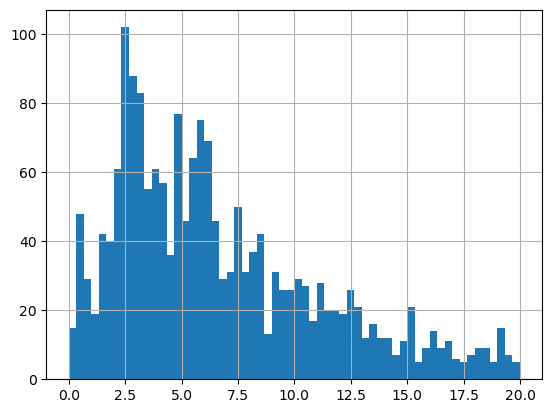

In [24]:
new_y.hist(bins=60)

In [25]:
filled_df = filled_df[filled_df['y'] < delete_y]

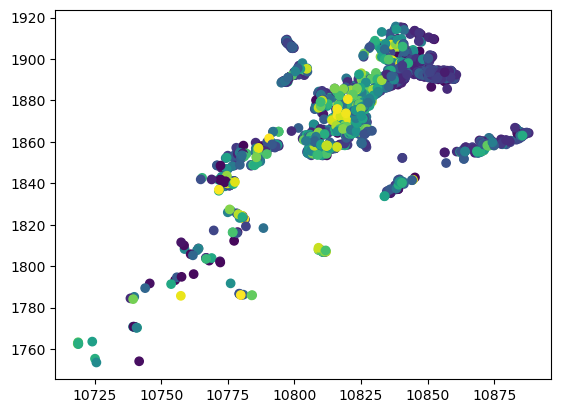

In [26]:
plt.scatter(filled_df['x_1'], filled_df['x_2'], c=filled_df['y'])
plt.show()

# Scaling

In [27]:
def create_scaler(x_train, y_train, other_f):
    scaler = {}

    if(len(other_f) > 0):
        scaler["feats"] = StandardScaler().fit(x_train[other_f])

    scaler["target"] = StandardScaler().fit(y_train.reshape([-1, 1]))

    return scaler

def apply_features(scaler, x_train, x_test, y_train, y_test, other_f):
    if(len(other_f) > 0):
        x_train[other_f] = scaler["feats"].transform(x_train[other_f])
        x_test[other_f] = scaler["feats"].transform(x_test[other_f])

    y_train = scaler["target"].transform(y_train.reshape([-1, 1])).reshape([-1])
    y_test = scaler["target"].transform(y_test.reshape([-1, 1])).reshape([-1])

    return (x_train, x_test),(y_train, y_test)

def scale_features(x_train, x_test, y_train, y_test, other_f):
    scaler = create_scaler(x_train, y_train, other_f)

    return scaler, *apply_features(scaler, x_train, x_test, y_train, y_test, other_f)


# Работа с моделями

### Метрики и всякое

In [28]:
def MSE(pred, y):
    return ((pred - y)**2).mean()

def MAE(pred, y):
    return (np.abs(pred - y)).mean()

In [29]:
def my_metrics(pred_train, pred_test, y_train, y_test):
    print("Test part")
    print(f"MSE {MSE(pred_test, y_test)}")
    print(f"MAE {MAE(pred_test, y_test)}\n")

    return MSE(pred_test, y_test), MAE(pred_test, y_test)

In [30]:
def metric_fs(pred_train, pred_test, y_train, y_test):
    return {"compare" : MSE(pred_test, y_test), 
            "test_mse" : MSE(pred_test, y_test),
            "train_mse" : MSE(pred_train, y_train)}

In [31]:
def learn_model(df, model_obj, use_features = [],need_scaling = False, need_new_features = False):
    x_train, x_test, y_train, y_test = train_test_split(df[use_features], df['y'].to_numpy(), train_size=0.8)

    dict_ret = {}

    if(need_scaling):
        dict_ret["scaler"], (x_train, x_test), (y_train, y_test) = scale_features(x_train, x_test, y_train, y_test, use_features)
    
    dict_ret["y"] = {"train":y_train, "test":y_test}
    
    if(need_new_features):
        x_train = add_features(x_train, use_features)
        x_test = add_features(x_test, use_features)

    dict_ret["x"] = {"train":x_train, "test":x_test}

    dict_ret["model"] = model_obj.fit(x_train, y_train)

    return dict_ret

In [32]:
def eval_model(df, model_obj, metric, use_feats, need_scaling = False, need_new_features = False):
    get_model = learn_model(df, model_obj, use_feats, need_scaling, need_new_features)

    pred_train = get_model['model'].predict(get_model['x']['train'])
    pred_test = get_model['model'].predict(get_model['x']['test'])

    if(need_scaling):
        pred_train = get_model['scaler']['target'].inverse_transform(pred_train.reshape([-1, 1]))
        pred_test = get_model['scaler']['target'].inverse_transform(pred_test.reshape([-1, 1]))

    
    return get_model, metric(pred_train, pred_test, get_model['y']['train'],get_model['y']['test'])



Std Scaler - мешает

In [33]:
eval_model(filled_df, LinearRegression(), my_metrics, ["x_1", "x_2"] + unknown_features, need_scaling=True)

eval_model(filled_df, LinearRegression(), my_metrics, ["x_1", "x_2"] + unknown_features)
print()

Test part
MSE 51.221347099319615
MAE 6.828211302994532

Test part
MSE 19.704305592409927
MAE 3.532498076944536




От набора данных в которых не заполнены, а удалены выбросы - толку нет

In [34]:
eval_model(clear_df, LinearRegression(), my_metrics, ["x_1", "x_2"] + unknown_features, need_scaling=True)

eval_model(clear_df, LinearRegression(), my_metrics, ["x_1", "x_2"] + unknown_features)
print()

Test part
MSE 138.4906067685205
MAE 10.80112390981621

Test part
MSE 83.25583338785084
MAE 6.1363960960144945




От координат - толку нет

In [35]:
eval_model(filled_df, LinearRegression(), my_metrics, unknown_features)

eval_model(filled_df, LinearRegression(), my_metrics, ["x_1", "x_2"] + unknown_features)
print()

Test part
MSE 18.49625555322915
MAE 3.33638452853099

Test part
MSE 17.63563148795263
MAE 3.1951866858200217




Создаем расширенный датасет

In [36]:
full_filled_df = add_features(filled_df, unknown_features)
full_filled_df = add_features(full_filled_df, cords_features)

In [37]:
full_feats = list(set(full_filled_df.columns)^set(["y", "name"]))

In [38]:
len(full_feats)

345

In [39]:
eval_model(filled_df, LinearRegression(), my_metrics, unknown_features)

eval_model(full_filled_df, LinearRegression(), my_metrics, full_feats)
print()

Test part
MSE 22.301677428385023
MAE 3.652196132509007

Test part
MSE 41.575243105505855
MAE 3.7433097721854627




 # Forward Selection

In [40]:
def remove_feats(used_feats, choosen_feat):
    for feat in choosen_feat.split("-"):
        used_feats = [u_feat for u_feat in used_feats if not(feat in u_feat.split('-'))]

    return used_feats

In [41]:
def forward_selection(df, model_obj, metric, used_feats=[], selected_feats = [], need_stop = True, need_scaling = False, choose_feats = -1, splits = 3):
    prev_min_metric = np.inf
    folds = KFold(n_splits=splits, shuffle=True)
    
    scores = []
    
    if(choose_feats < 1):
        choose_feats = len(used_feats)

    print(choose_feats)
    with tqdm(range(choose_feats)) as epochs:
        for epoch in epochs:
            min_metric = np.inf
            choosen = None

            if(len(used_feats) < 1):

                break
            
            with tqdm(used_feats, total=len(used_feats), leave = False) as feature_iter:
                for feat in  feature_iter:
                    
                    cur_metric = 0
                    for train_index, valid_index in folds.split(df):
                        get_model, metric_val = eval_model(df.iloc[train_index], model_obj, metric, selected_feats + [feat],need_scaling)

                        pred_valid = get_model['model'].predict(df[selected_feats + [feat]].iloc[valid_index])
                        pred_train = get_model['model'].predict(df[selected_feats + [feat]].iloc[train_index])
                        cur_metric += metric(pred_train, pred_valid, df.iloc[train_index]['y'], df.iloc[valid_index]['y'])['compare']
                    cur_metric /= splits

                    if(cur_metric < min_metric):
                        min_metric = cur_metric
                        choosen = feat
                        
                    feature_iter.set_description(f"Selected feature {choosen}, metric {min_metric}")

            if(need_stop and (min_metric > prev_min_metric)):
                print("Metric gets bigger")
                break
            prev_min_metric = min_metric
            scores += [min_metric]
            print(choosen, min_metric)
            
            selected_feats += [choosen]
            used_feats = remove_feats(used_feats, choosen)
            
            epochs.total = max(len(used_feats) + len(selected_feats), choose_feats)
            epochs.refresh()
            
    plt.plot(range(len(scores)),scores)
    plt.show()

    return selected_feats, scores


42


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

x_8 18.935840216466236


  0%|          | 0/41 [00:00<?, ?it/s]

x_2 18.403406587649258


  0%|          | 0/40 [00:00<?, ?it/s]

x_7 18.290361021206724


  0%|          | 0/39 [00:00<?, ?it/s]

x_23 18.098613959702796


  0%|          | 0/38 [00:00<?, ?it/s]

x_1 17.904095820574128


  0%|          | 0/37 [00:00<?, ?it/s]

dist_cluster6 17.852872425704692


  0%|          | 0/36 [00:00<?, ?it/s]

x_16 17.768848828983817


  0%|          | 0/35 [00:00<?, ?it/s]

cluster6 17.75487922519808


  0%|          | 0/34 [00:00<?, ?it/s]

x_17 17.64967328305267


  0%|          | 0/33 [00:00<?, ?it/s]

x_26 17.610873508561706


  0%|          | 0/32 [00:00<?, ?it/s]

x_13 17.48718612661528


  0%|          | 0/31 [00:00<?, ?it/s]

x_5 17.40183989250302


  0%|          | 0/30 [00:00<?, ?it/s]

x_18 17.407068090428574


  0%|          | 0/29 [00:00<?, ?it/s]

dist_cluster1 17.47368216578805


  0%|          | 0/28 [00:00<?, ?it/s]

x_6 17.473741686436377


  0%|          | 0/27 [00:00<?, ?it/s]

dist_cluster7 17.44089271294422


  0%|          | 0/26 [00:00<?, ?it/s]

x_25 17.41154350261093


  0%|          | 0/25 [00:00<?, ?it/s]

cluster1 17.399880436265004


  0%|          | 0/24 [00:00<?, ?it/s]

x_14 17.457670782983204


  0%|          | 0/23 [00:00<?, ?it/s]

x_3 17.37783439149132


  0%|          | 0/22 [00:00<?, ?it/s]

cluster7 17.43275813778306


  0%|          | 0/21 [00:00<?, ?it/s]

x_22 17.442326780276574


  0%|          | 0/20 [00:00<?, ?it/s]

x_24 17.528630978867884


  0%|          | 0/19 [00:00<?, ?it/s]

dist_cluster0 17.476323851796863


  0%|          | 0/18 [00:00<?, ?it/s]

x_11 17.500855486217567


  0%|          | 0/17 [00:00<?, ?it/s]

dist_cluster5 17.412490812948093


  0%|          | 0/16 [00:00<?, ?it/s]

x_9 17.612615089012536


  0%|          | 0/15 [00:00<?, ?it/s]

dist_cluster2 17.589725288449166


  0%|          | 0/14 [00:00<?, ?it/s]

dist_cluster4 17.61491517442073


  0%|          | 0/13 [00:00<?, ?it/s]

x_12 17.564486943979134


  0%|          | 0/12 [00:00<?, ?it/s]

x_10 17.601595285198314


  0%|          | 0/11 [00:00<?, ?it/s]

cluster2 17.579251347055845


  0%|          | 0/10 [00:00<?, ?it/s]

cluster3 17.573312738175904


  0%|          | 0/9 [00:00<?, ?it/s]

dist_cluster3 17.4997409139051


  0%|          | 0/8 [00:00<?, ?it/s]

x_4 17.664268852391366


  0%|          | 0/7 [00:00<?, ?it/s]

x_15 17.752252293400744


  0%|          | 0/6 [00:00<?, ?it/s]

x_20 17.748726895932702


  0%|          | 0/5 [00:00<?, ?it/s]

cluster0 17.615628411138765


  0%|          | 0/4 [00:00<?, ?it/s]

cluster5 17.9164575994509


  0%|          | 0/3 [00:00<?, ?it/s]

x_21 17.925693511633654


  0%|          | 0/2 [00:00<?, ?it/s]

cluster4 18.064285002852866


  0%|          | 0/1 [00:00<?, ?it/s]

x_19 18.267907289837066


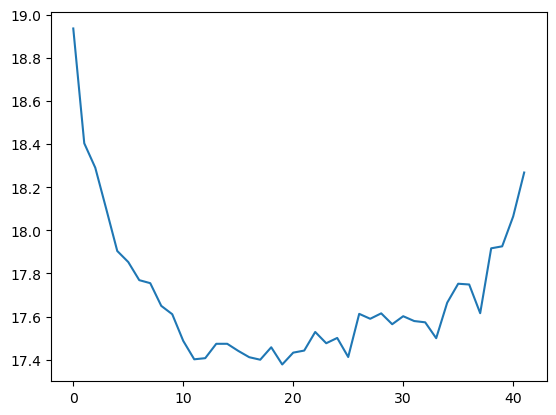

CPU times: total: 1min 20s
Wall time: 2min 13s


In [42]:
%%time

train, test = train_test_split(full_filled_df, train_size=0.8)
selected_features, scores = forward_selection(full_filled_df, LinearRegression(), metric_fs, unknown_features + cords_features + cluster_feats + dist_feats ,need_stop = False, splits=4)

In [43]:
first_n = np.argmin(scores) + 1

print(first_n)
model_smth = learn_model(train, LinearRegression(), selected_features[:first_n])

pred = model_smth['model'].predict(test[selected_features[:first_n]])

print("Short", MSE(pred, test['y']), MAE(pred, test['y']))

model_smth = learn_model(train, LinearRegression(), selected_features)

pred = model_smth['model'].predict(test[selected_features])

print("Long", MSE(pred, test['y']), MAE(pred, test['y']))

20
Short 17.68510738179855 3.270269259478617
Long 18.41015368697722 3.310403356160461


345


  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 0/345 [00:00<?, ?it/s]

x_23-x_8 17.568005203497833


  0%|          | 0/296 [00:00<?, ?it/s]

x_12-x_12 17.538212571300605


  0%|          | 0/273 [00:00<?, ?it/s]

x_24-x_24 17.549560766367676


  0%|          | 0/251 [00:00<?, ?it/s]

x_26-x_20 17.478708501273665


  0%|          | 0/210 [00:00<?, ?it/s]

x_25 17.54234899048609


  0%|          | 0/191 [00:00<?, ?it/s]

x_9 17.512454305036687


  0%|          | 0/173 [00:00<?, ?it/s]

x_21-x_14 17.588790046141487


  0%|          | 0/140 [00:00<?, ?it/s]

x_5-x_4 17.498145015967573


  0%|          | 0/111 [00:00<?, ?it/s]

x_22-x_6 17.464126507158646


  0%|          | 0/86 [00:00<?, ?it/s]

x_16-x_10 17.382383654965167


  0%|          | 0/65 [00:00<?, ?it/s]

cluster4 17.56591617024519


  0%|          | 0/64 [00:00<?, ?it/s]

x_13-x_3 17.648134514880446


  0%|          | 0/47 [00:00<?, ?it/s]

x_18-x_18 17.591811948464287


  0%|          | 0/40 [00:00<?, ?it/s]

x_15-x_11 17.736481826551735


  0%|          | 0/29 [00:00<?, ?it/s]

x_17-x_17 17.637186925326574


  0%|          | 0/25 [00:00<?, ?it/s]

x_2 17.50738198856922


  0%|          | 0/22 [00:00<?, ?it/s]

dist_cluster6 17.510721081466116


  0%|          | 0/21 [00:00<?, ?it/s]

dist_cluster3 17.63055635243488


  0%|          | 0/20 [00:00<?, ?it/s]

cluster6 17.326281615580445


  0%|          | 0/19 [00:00<?, ?it/s]

cluster1 17.453340270559707


  0%|          | 0/18 [00:00<?, ?it/s]

dist_cluster1 17.371019325309057


  0%|          | 0/17 [00:00<?, ?it/s]

dist_cluster4 17.486784646601425


  0%|          | 0/16 [00:00<?, ?it/s]

dist_cluster2 17.495398626368278


  0%|          | 0/15 [00:00<?, ?it/s]

x_19 17.556761070659167


  0%|          | 0/12 [00:00<?, ?it/s]

dist_cluster0 17.580283395942175


  0%|          | 0/11 [00:00<?, ?it/s]

cluster2 17.661289047870135


  0%|          | 0/10 [00:00<?, ?it/s]

cluster0 17.598595903879513


  0%|          | 0/9 [00:00<?, ?it/s]

dist_cluster7 17.599466019976166


  0%|          | 0/8 [00:00<?, ?it/s]

dist_cluster5 17.47065884774713


  0%|          | 0/7 [00:00<?, ?it/s]

cluster7 17.678333186078458


  0%|          | 0/6 [00:00<?, ?it/s]

x_7-x_7 17.627790239915672


  0%|          | 0/4 [00:00<?, ?it/s]

cluster3 17.805930713877565


  0%|          | 0/3 [00:00<?, ?it/s]

cluster5 17.828241706390138


  0%|          | 0/2 [00:00<?, ?it/s]

x_1-x_1 18.02322428175247


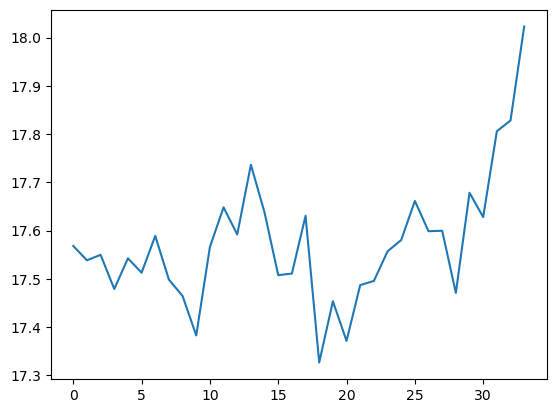

CPU times: total: 3min 41s
Wall time: 7min 48s


In [44]:
%%time

train, test = train_test_split(full_filled_df, train_size=0.8)
selected_features, scores = forward_selection(full_filled_df, LinearRegression(), metric_fs, full_feats, need_stop = False, splits=4)

In [45]:
first_n = np.argmin(scores) + 1
print(first_n)
model_smth = learn_model(train, LinearRegression(), selected_features[:first_n])

pred = model_smth['model'].predict(test[selected_features[:first_n]])

print("Short", MSE(pred, test['y']), MAE(pred, test['y']))

model_smth = learn_model(train, LinearRegression(), selected_features)

pred = model_smth['model'].predict(test[selected_features])

print("Long", MSE(pred, test['y']), MAE(pred, test['y']))

19
Short 17.702173712633446 3.2032589509222213
Long 17.516590859635066 3.184266214342318


Итог: модель слишком сильно переобучается, кажется не хватает данных для forward Selection

(Без использования kfold, получалось переобучиться на трейне и на валиде до valid_MSE ~ 0.001)